In [153]:
%matplotlib inline

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd
import copy
from pyquaternion import Quaternion

In [161]:
import math

def quaternion_to_euler(w, x, y, z):
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        X = math.degrees(math.atan2(t0, t1))

        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        Y = math.degrees(math.asin(t2))

        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        Z = math.degrees(math.atan2(t3, t4))

        return X, Y, Z
    
    
def quaternion_to_euler_2(w, x, y, z):    
    sqw = w*w
    sqx = x*x
    sqy = y*y
    sqz = z*z
    unit = sqx + sqy + sqz + sqw # if normalised is one, otherwise is correction factor
    test = x*y + z*w
    if test > 0.499*unit: # singularity at north pole
        heading = 2 * math.atan2(x,w)
        attitude = math.PI/2
        bank = 0
        return heading, attitude, bank

    if test < -0.499*unit: # singularity at south pole
        heading = -2 * math.atan2(x,w)
        attitude = -math.PI/2
        bank = 0
        return heading, attitude, bank

    heading = math.atan2(2*y*w-2*x*z , sqx - sqy - sqz + sqw)
    attitude = math.asin(2*test/unit)
    bank = math.atan2(2*x*w-2*y*z , -sqx + sqy - sqz + sqw)
    return heading, attitude, bank

In [74]:
mydf = pd.read_csv('C:\IAAA\TER\data\ACORFORMED\Data\N7A\Casque\Unity\N7A-Casque-Unity-out_record_DATE17-2-27_13-29-57.txt', sep='\t')
points_subject = ['HeadSubject', 'LeftWristSubject', 'RightWristSubject', 'LeftElbowSubject', 'RightElbowSubject', 'master']
points_agent = ['Head', 'LeftHand', 'RightHand', 'LeftArm', 'RightArm', 'master']
points = points_subject
df = mydf

In [103]:
all = []
points = points_subject
for point in points:
    all.append(point+'_posx')
    all.append(point+'_posy')
    all.append(point+'_posz')
    all.append(point+'_quax')
    all.append(point+'_quay')
    all.append(point+'_quaz')    
    all.append(point+'_quaw')    
df = mydf.drop_duplicates(subset=all)
print(len(df))

11049


<IPython.core.display.Javascript object>


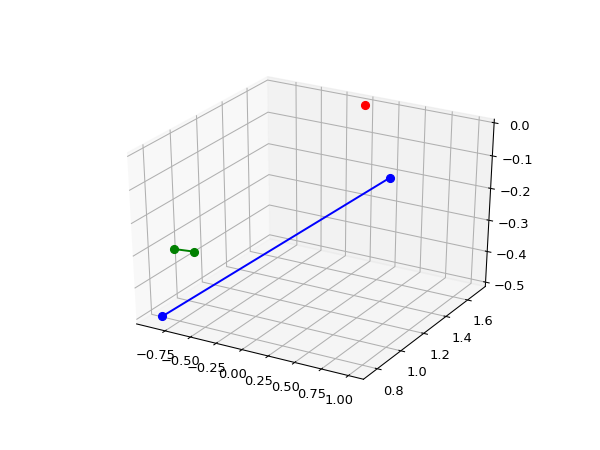

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

data = df.iloc[0]

# head
ax.plot([data[points[0]+'_posx']], [data[points[0]+'_posy']], [data[points[0]+'_posz']], linestyle="", marker='o', c='r') 
ax.plot([data[points[1]+'_posx'], data[points[3]+'_posx']], [data[points[1]+'_posy'], data[points[3]+'_posy']], [data[points[1]+'_posz'], data[points[3]+'_posz']], linestyle="-", marker='o', c='b')
ax.plot([data[points[2]+'_posx'], data[points[4]+'_posx']], [data[points[2]+'_posy'], data[points[4]+'_posy']], [data[points[2]+'_posz'], data[points[4]+'_posz']], linestyle="-", marker='o', c='g')

12759


<IPython.core.display.Javascript object>


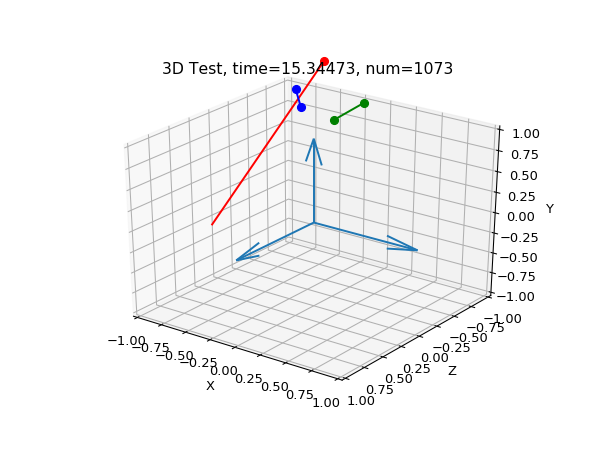

In [110]:
print(len(df))
df = mydf

#a = np.random.rand(2000, 3)*10
#t = np.array([np.ones(100)*i for i in range(20)]).flatten()
#df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})
#print(a)
#print(t)
points_subject = ['HeadSubject', 'LeftWristSubject', 'RightWristSubject', 'LeftElbowSubject', 'RightElbowSubject']
points_agent = ['Head', 'LeftHand', 'RightHand', 'LeftArm', 'RightArm']
markers = ['D', 'o', '<', '>', '3', '4', 'x']
colors = ['r', 'orange', 'g', 'g', 'b', 'b', 'black']
graphs = []

points = points_subject
type = 'p'

def vect(v):
    u = copy.copy(v)
    # switch Y and Z axis
    u[1] = v[2]
    u[2] = v[1]
    """if isinstance(v[1], basestring):
        u[2] = v[1]
    else:
        u[2] = -v[1]"""
    return u

def get_quaternion(df, num, point):
    data = df.iloc[num]
    return Quaternion(x=data[point+'_quaw'], y=data[point+'_quax'], z=data[point+'_quay'], w=data[point+'_quaz'])

def get_coords_q(df, num, point):
    data=df.iloc[num]
    v = np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']])
    q = get_quaternion(df, num, point)
    v = q.rotate(v)
    return vect(v)

def get_coords_p(df, num, point):
    data=df.iloc[num]
    #print(np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']]))
    return vect(np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']]))

def get_coords(df, num, point):
    if type == 'p':
        return get_coords_p(df, num, point)
    else:
        return get_coords_q(df, num, point)

def update_graph(num):
    data=df.iloc[num]
    """for idx, point in enumerate(points):
        #x = data[[col+'_posx' for col in points]]
        #y = data[[col+'_posy' for col in points]]
        #z = data[[col+'_posz' for col in points]]
        v = np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']])
        q = Quaternion(x=data[point+'_quax'], y=data[point+'_quay'], z=data[point+'_quaz'], w=data[point+'_quaw'])
        v = q.rotate(v)
        graphs[idx].set_data (v[0], v[1])
        graphs[idx].set_3d_properties(v[2])"""
    v = get_coords(df, num, points[0])
    head.set_data(v[0], v[1])
    head.set_3d_properties(v[2])
    
    q = get_quaternion(df, num, points[0])
    hv = q.rotate([1,0,0])
    head_orientation.set_segments([[ [v[0], v[1], v[2]], [hv[0], hv[1], hv[2]] ]])
    #= ax.quiver(v[0], v[1], v[2], hv[0], hv[1], hv[2], color='r')    
    
    v1 = get_coords(df, num, points[1])
    v2 = get_coords(df, num, points[3])
    left.set_data([v1[0], v2[0]], [v1[1], v2[1]])
    left.set_3d_properties([v1[2], v2[2]])
    v1 = get_coords(df, num, points[2])
    v2 = get_coords(df, num, points[4])
    right.set_data([v1[0], v2[0]], [v1[1], v2[1]])
    right.set_3d_properties([v1[2], v2[2]])
        
    title.set_text('3D Test, time={}, num={}'.format(data['chrono'], num))
    return title, head, left, right


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df.iloc[0]
#df[df['chrono']==0]
#graphs = [ax.plot([data[point+'_posx']], [data[point+'_posy']], [data[point+'_posz']], linestyle="", marker=markers[idx], c=colors[idx])[0] for idx, point in enumerate(points)]

graphs = []
v = get_coords(df, 0, points[0])
head = ax.plot([v[0]], [v[1]], [v[2]], linestyle="", marker='o', c='r')[0]

q = get_quaternion(df, 0, points[0])
hv = q.rotate([1,0,0])
head_orientation = ax.quiver(v[0], v[1], v[2], hv[0], hv[1], hv[2], color='r')


v1 = get_coords(df, 0, points[1])
v2 = get_coords(df, 0, points[3])
left = ax.plot([v1[0], v2[0]], [v1[1], v2[1]], [v1[2], v2[2]], linestyle="-", marker='o', c='b')[0]
v1 = get_coords(df, 0, points[2])
v2 = get_coords(df, 0, points[4])
right = ax.plot([v1[0], v2[0]], [v1[1], v2[1]], [v1[2], v2[2]], linestyle="-", marker='o', c='g')[0]




#print(graphs)

#graph, = ax.plot([data[point+'_posx']], [data[point+'_posy']], [data[point+'_posz']], linestyle="", marker="o")
#ax.set_xlim(xmin=df[point+'_posx'].min(), xmax=df[point+'_posx'].max())
#ax.set_ylim(ymin=df[point+'_posy'].min(), ymax=df[point+'_posy'].max())
#ax.set_zlim(zmin=df[point+'_posz'].min(), zmax=df[point+'_posz'].max())
#print(np.amin(df[[col+'_posx' for col in points]].values))

#ax.set_xlim(np.amin(df[[col+'_posx' for col in points]].values), np.amax(df[[col+'_posx' for col in points]].max(axis=None).values))
#ax.set_ylim(np.amin(df[[col+'_posy' for col in points]].values), np.amax(df[[col+'_posy' for col in points]].max(axis=None).values))
#ax.set_zlim(np.amin(df[[col+'_posz' for col in points]].values), np.amax(df[[col+'_posz' for col in points]].max(axis=None).values))

dim = 1
ax.set_xlim(-dim, dim)
ax.set_ylim(dim, -dim)
ax.set_zlim(-dim, dim)
coords = ['X', 'Y', 'Z']
ax.set_xlabel(vect(coords)[0])
ax.set_ylabel(vect(coords)[1])
ax.set_zlabel(vect(coords)[2])

x = [0,0,0]
u = [1,0,0]
v = [0,1,0]
w = [0,0,1]
ax.quiver(x, x, x, vect(u), vect(v), vect(w))

ani = matplotlib.animation.FuncAnimation(fig, update_graph, np.arange(0, len(df), 1), 
                                interval=10, blit=True)

plt.show()

In [176]:
from IPython.core.display import display, HTML
point = 'Head'
#q = [get_quaternion(df, num, point) for num in np.arange(len(df))]


d = df[['chrono', point+'_quax', point+'_quay', point+'_quaz', point+'_quaw']]
d = d.drop_duplicates()
print(len(d))
#display(HTML(d[['HeadSubject_quax', 'HeadSubject_quay', 'HeadSubject_quaz', 'HeadSubject_quaw']].to_html()))
accel = np.zeros((len(df), 3), dtype='float64')
angles = np.zeros((len(df), 3), dtype='float64')
pyaw, ppitch, proll = 0,0,0
for i in np.arange(len(df)):
    q = get_quaternion(d, i, point)
    #print("%f / %s / axis %s angle %f / %f, %f, %f, %f" % (d['chrono'].iloc[i], str(q), str(q.axis), q.angle, d.iloc[i][point+'_quax'], d.iloc[i][point+'_quay'], d.iloc[i][point+'_quaz'], d.iloc[i][point+'_quaw']))
    #x,y,z,w = d.iloc[i]['HeadSubject_quax'], d.iloc[i]['HeadSubject_quay'], d.iloc[i]['HeadSubject_quaz'], d.iloc[i]['HeadSubject_quaw']
    #print("x %f y %f z %f w %f" % (x,y,z,w))
    #q = Quaternion(x,y,z,w)
    #print("axis %s angle %f" % (q.axis, q.angle))
    yaw, pitch, roll = quaternion_to_euler_2(q.w, q.x, q.y, q.z)
    yaw, pitch, roll = abs(yaw), abs(pitch), abs(roll)
    if i == 0:
        pyaw, ppitch, proll = yaw, pitch, roll
    #print('yaw %f pitch %f roll %f' % (yaw, pitch, roll))
    accel[i,:] = [yaw-pyaw, pitch-ppitch, roll-proll]
    angles[i,:] = [yaw, pitch, roll]
    print('yaw %f %f %f' % (pyaw, yaw, yaw-pyaw))
    pyaw, ppitch, proll = yaw,pitch,roll
#print('MEAN %s STD %s' % (str(np.mean(angles, axis=1)), str(np.std(angles, axis=1))))
display(HTML(pd.DataFrame(data=angles, columns=['yaw', 'pitch', 'roll']).describe().to_html()))
display(HTML(pd.DataFrame(data=accel, columns=['yaw a', 'pitch a', 'roll a']).describe().to_html()))
"""a1 = [qua.axis[0] for qua in q]
a2 = [qua.axis[1] for qua in q]
a3 = [qua.axis[2] for qua in q]
angle = [qua.angle for qua in q]
plt.plot(df['chrono'], a1, label='rot x')
plt.plot(df['chrono'], a2, label='rot y')
plt.plot(df['chrono'], a3, label='rot z')
plt.plot(df['chrono'], angle, label='rot angle')"""
#plt.plot(df['chrono'], df[point+'_posx'], label=point+'_posx')
#plt.plot(df['chrono'], df[point+'_posy'], label=point+'_posy')
#plt.plot(df['chrono'], df[point+'_posz'], label=point+'_posz')
"""plt.plot(df['chrono'], angles[:, 0], label='yaw')
plt.legend()
plt.show()"""



12759
yaw 0.408000 0.408000 0.000000
yaw 0.408000 0.408000 0.000000
yaw 0.408000 0.408000 0.000000
yaw 0.408000 0.408492 0.000492
yaw 0.408492 0.408492 0.000000
yaw 0.408492 0.408492 0.000000
yaw 0.408492 0.409049 0.000557
yaw 0.409049 0.409049 0.000000
yaw 0.409049 0.409635 0.000586
yaw 0.409635 0.409635 0.000000
yaw 0.409635 0.409635 0.000000
yaw 0.409635 0.410280 0.000645
yaw 0.410280 0.410280 0.000000
yaw 0.410280 0.410280 0.000000
yaw 0.410280 0.410913 0.000632
yaw 0.410913 0.410913 0.000000
yaw 0.410913 0.410913 0.000000
yaw 0.410913 0.411559 0.000646
yaw 0.411559 0.411559 0.000000
yaw 0.411559 0.411559 0.000000
yaw 0.411559 0.412219 0.000660
yaw 0.412219 0.412219 0.000000
yaw 0.412219 0.412869 0.000650
yaw 0.412869 0.412869 0.000000
yaw 0.412869 0.412869 0.000000
yaw 0.412869 0.413550 0.000681
yaw 0.413550 0.413550 0.000000
yaw 0.413550 0.413550 0.000000
yaw 0.413550 0.414217 0.000668
yaw 0.414217 0.414217 0.000000
yaw 0.414217 0.414217 0.000000
yaw 0.414217 0.414937 0.000720
ya

yaw 0.423229 0.423229 0.000000
yaw 0.423229 0.423387 0.000158
yaw 0.423387 0.423387 0.000000
yaw 0.423387 0.423387 0.000000
yaw 0.423387 0.423538 0.000150
yaw 0.423538 0.423538 0.000000
yaw 0.423538 0.423538 0.000000
yaw 0.423538 0.423695 0.000157
yaw 0.423695 0.423695 0.000000
yaw 0.423695 0.423695 0.000000
yaw 0.423695 0.423887 0.000192
yaw 0.423887 0.423887 0.000000
yaw 0.423887 0.423887 0.000000
yaw 0.423887 0.424107 0.000220
yaw 0.424107 0.424107 0.000000
yaw 0.424107 0.424320 0.000213
yaw 0.424320 0.424320 0.000000
yaw 0.424320 0.424320 0.000000
yaw 0.424320 0.424563 0.000243
yaw 0.424563 0.424563 0.000000
yaw 0.424563 0.424563 0.000000
yaw 0.424563 0.424810 0.000247
yaw 0.424810 0.424810 0.000000
yaw 0.424810 0.424810 0.000000
yaw 0.424810 0.425060 0.000250
yaw 0.425060 0.425060 0.000000
yaw 0.425060 0.425060 0.000000
yaw 0.425060 0.425316 0.000256
yaw 0.425316 0.425316 0.000000
yaw 0.425316 0.425584 0.000267
yaw 0.425584 0.425584 0.000000
yaw 0.425584 0.425584 0.000000
yaw 0.42

yaw 0.410559 0.410559 0.000000
yaw 0.410559 0.410581 0.000022
yaw 0.410581 0.410581 0.000000
yaw 0.410581 0.410581 0.000000
yaw 0.410581 0.410663 0.000082
yaw 0.410663 0.410663 0.000000
yaw 0.410663 0.410814 0.000151
yaw 0.410814 0.410814 0.000000
yaw 0.410814 0.410814 0.000000
yaw 0.410814 0.411016 0.000202
yaw 0.411016 0.411016 0.000000
yaw 0.411016 0.411016 0.000000
yaw 0.411016 0.411305 0.000289
yaw 0.411305 0.411305 0.000000
yaw 0.411305 0.411305 0.000000
yaw 0.411305 0.411640 0.000336
yaw 0.411640 0.411640 0.000000
yaw 0.411640 0.411640 0.000000
yaw 0.411640 0.412071 0.000431
yaw 0.412071 0.412071 0.000000
yaw 0.412071 0.412558 0.000487
yaw 0.412558 0.412558 0.000000
yaw 0.412558 0.412558 0.000000
yaw 0.412558 0.413105 0.000547
yaw 0.413105 0.413105 0.000000
yaw 0.413105 0.413105 0.000000
yaw 0.413105 0.413623 0.000518
yaw 0.413623 0.413623 0.000000
yaw 0.413623 0.413623 0.000000
yaw 0.413623 0.414207 0.000584
yaw 0.414207 0.414207 0.000000
yaw 0.414207 0.414207 0.000000
yaw 0.41

yaw 0.417038 0.417038 0.000000
yaw 0.417038 0.417038 0.000000
yaw 0.417038 0.417417 0.000379
yaw 0.417417 0.417417 0.000000
yaw 0.417417 0.417417 0.000000
yaw 0.417417 0.417819 0.000403
yaw 0.417819 0.417819 0.000000
yaw 0.417819 0.418212 0.000393
yaw 0.418212 0.418212 0.000000
yaw 0.418212 0.418212 0.000000
yaw 0.418212 0.418523 0.000311
yaw 0.418523 0.418523 0.000000
yaw 0.418523 0.418523 0.000000
yaw 0.418523 0.418742 0.000219
yaw 0.418742 0.418742 0.000000
yaw 0.418742 0.418742 0.000000
yaw 0.418742 0.419033 0.000291
yaw 0.419033 0.419033 0.000000
yaw 0.419033 0.419033 0.000000
yaw 0.419033 0.419341 0.000309
yaw 0.419341 0.419341 0.000000
yaw 0.419341 0.419615 0.000274
yaw 0.419615 0.419615 0.000000
yaw 0.419615 0.419615 0.000000
yaw 0.419615 0.419867 0.000252
yaw 0.419867 0.419867 0.000000
yaw 0.419867 0.419867 0.000000
yaw 0.419867 0.420166 0.000299
yaw 0.420166 0.420166 0.000000
yaw 0.420166 0.420166 0.000000
yaw 0.420166 0.420455 0.000290
yaw 0.420455 0.420455 0.000000
yaw 0.42

yaw 0.407558 0.407558 0.000000
yaw 0.407558 0.404213 -0.003345
yaw 0.404213 0.404213 0.000000
yaw 0.404213 0.404213 0.000000
yaw 0.404213 0.400814 -0.003399
yaw 0.400814 0.400814 0.000000
yaw 0.400814 0.400814 0.000000
yaw 0.400814 0.397771 -0.003043
yaw 0.397771 0.397771 0.000000
yaw 0.397771 0.395050 -0.002721
yaw 0.395050 0.395050 0.000000
yaw 0.395050 0.395050 0.000000
yaw 0.395050 0.392646 -0.002404
yaw 0.392646 0.392646 0.000000
yaw 0.392646 0.392646 0.000000
yaw 0.392646 0.390578 -0.002068
yaw 0.390578 0.390578 0.000000
yaw 0.390578 0.390578 0.000000
yaw 0.390578 0.388780 -0.001797
yaw 0.388780 0.388780 0.000000
yaw 0.388780 0.388780 0.000000
yaw 0.388780 0.387277 -0.001504
yaw 0.387277 0.387277 0.000000
yaw 0.387277 0.386041 -0.001236
yaw 0.386041 0.386041 0.000000
yaw 0.386041 0.386041 0.000000
yaw 0.386041 0.384958 -0.001082
yaw 0.384958 0.384958 0.000000
yaw 0.384958 0.384958 0.000000
yaw 0.384958 0.384194 -0.000764
yaw 0.384194 0.384194 0.000000
yaw 0.384194 0.384194 0.0000

yaw 0.385949 0.386772 0.000823
yaw 0.386772 0.386772 0.000000
yaw 0.386772 0.386772 0.000000
yaw 0.386772 0.387707 0.000935
yaw 0.387707 0.387707 0.000000
yaw 0.387707 0.387707 0.000000
yaw 0.387707 0.388567 0.000860
yaw 0.388567 0.388567 0.000000
yaw 0.388567 0.389695 0.001128
yaw 0.389695 0.389695 0.000000
yaw 0.389695 0.389695 0.000000
yaw 0.389695 0.390869 0.001174
yaw 0.390869 0.390869 0.000000
yaw 0.390869 0.391953 0.001083
yaw 0.391953 0.391953 0.000000
yaw 0.391953 0.391953 0.000000
yaw 0.391953 0.392939 0.000986
yaw 0.392939 0.392939 0.000000
yaw 0.392939 0.392939 0.000000
yaw 0.392939 0.393880 0.000941
yaw 0.393880 0.393880 0.000000
yaw 0.393880 0.393880 0.000000
yaw 0.393880 0.394791 0.000911
yaw 0.394791 0.394791 0.000000
yaw 0.394791 0.394791 0.000000
yaw 0.394791 0.395603 0.000812
yaw 0.395603 0.395603 0.000000
yaw 0.395603 0.396397 0.000794
yaw 0.396397 0.396397 0.000000
yaw 0.396397 0.396397 0.000000
yaw 0.396397 0.397120 0.000723
yaw 0.397120 0.397120 0.000000
yaw 0.39

yaw 0.434160 0.433829 -0.000331
yaw 0.433829 0.433829 0.000000
yaw 0.433829 0.433829 0.000000
yaw 0.433829 0.433508 -0.000321
yaw 0.433508 0.433508 0.000000
yaw 0.433508 0.433508 0.000000
yaw 0.433508 0.433118 -0.000390
yaw 0.433118 0.433118 0.000000
yaw 0.433118 0.433118 0.000000
yaw 0.433118 0.432711 -0.000406
yaw 0.432711 0.432711 0.000000
yaw 0.432711 0.432711 0.000000
yaw 0.432711 0.432283 -0.000429
yaw 0.432283 0.432283 0.000000
yaw 0.432283 0.432283 0.000000
yaw 0.432283 0.431839 -0.000443
yaw 0.431839 0.431839 0.000000
yaw 0.431839 0.431348 -0.000492
yaw 0.431348 0.431348 0.000000
yaw 0.431348 0.431348 0.000000
yaw 0.431348 0.431348 0.000000
yaw 0.431348 0.430833 -0.000514
yaw 0.430833 0.430833 0.000000
yaw 0.430833 0.430833 0.000000
yaw 0.430833 0.430273 -0.000560
yaw 0.430273 0.430273 0.000000
yaw 0.430273 0.430273 0.000000
yaw 0.430273 0.429699 -0.000574
yaw 0.429699 0.429699 0.000000
yaw 0.429699 0.429109 -0.000590
yaw 0.429109 0.429109 0.000000
yaw 0.429109 0.429109 0.0000

yaw 0.388302 0.387232 -0.001070
yaw 0.387232 0.387232 0.000000
yaw 0.387232 0.387232 0.000000
yaw 0.387232 0.386472 -0.000760
yaw 0.386472 0.386472 0.000000
yaw 0.386472 0.386472 0.000000
yaw 0.386472 0.385999 -0.000473
yaw 0.385999 0.385999 0.000000
yaw 0.385999 0.385999 0.000000
yaw 0.385999 0.385753 -0.000247
yaw 0.385753 0.385753 0.000000
yaw 0.385753 0.385753 0.000000
yaw 0.385753 0.385764 0.000011
yaw 0.385764 0.385764 0.000000
yaw 0.385764 0.385924 0.000160
yaw 0.385924 0.385924 0.000000
yaw 0.385924 0.385924 0.000000
yaw 0.385924 0.386245 0.000321
yaw 0.386245 0.386245 0.000000
yaw 0.386245 0.386245 0.000000
yaw 0.386245 0.386692 0.000447
yaw 0.386692 0.386692 0.000000
yaw 0.386692 0.386692 0.000000
yaw 0.386692 0.387199 0.000507
yaw 0.387199 0.387199 0.000000
yaw 0.387199 0.387199 0.000000
yaw 0.387199 0.387835 0.000636
yaw 0.387835 0.387835 0.000000
yaw 0.387835 0.388556 0.000721
yaw 0.388556 0.388556 0.000000
yaw 0.388556 0.388556 0.000000
yaw 0.388556 0.389408 0.000852
yaw 

yaw 0.402022 0.402152 0.000130
yaw 0.402152 0.402152 0.000000
yaw 0.402152 0.402289 0.000137
yaw 0.402289 0.402289 0.000000
yaw 0.402289 0.402289 0.000000
yaw 0.402289 0.402373 0.000085
yaw 0.402373 0.402373 0.000000
yaw 0.402373 0.402373 0.000000
yaw 0.402373 0.402431 0.000057
yaw 0.402431 0.402431 0.000000
yaw 0.402431 0.402431 0.000000
yaw 0.402431 0.402537 0.000106
yaw 0.402537 0.402537 0.000000
yaw 0.402537 0.402537 0.000000
yaw 0.402537 0.402632 0.000095
yaw 0.402632 0.402632 0.000000
yaw 0.402632 0.402717 0.000085
yaw 0.402717 0.402717 0.000000
yaw 0.402717 0.402717 0.000000
yaw 0.402717 0.402761 0.000044
yaw 0.402761 0.402761 0.000000
yaw 0.402761 0.402761 0.000000
yaw 0.402761 0.402811 0.000051
yaw 0.402811 0.402811 0.000000
yaw 0.402811 0.402811 0.000000
yaw 0.402811 0.402836 0.000025
yaw 0.402836 0.402836 0.000000
yaw 0.402836 0.402836 0.000000
yaw 0.402836 0.402887 0.000051
yaw 0.402887 0.402887 0.000000
yaw 0.402887 0.402918 0.000031
yaw 0.402918 0.402918 0.000000
yaw 0.40

yaw 0.388546 0.387442 -0.001104
yaw 0.387442 0.387442 0.000000
yaw 0.387442 0.387442 0.000000
yaw 0.387442 0.386365 -0.001078
yaw 0.386365 0.386365 0.000000
yaw 0.386365 0.385338 -0.001026
yaw 0.385338 0.385338 0.000000
yaw 0.385338 0.385338 0.000000
yaw 0.385338 0.384423 -0.000915
yaw 0.384423 0.384423 0.000000
yaw 0.384423 0.384423 0.000000
yaw 0.384423 0.383645 -0.000778
yaw 0.383645 0.383645 0.000000
yaw 0.383645 0.383645 0.000000
yaw 0.383645 0.383040 -0.000604
yaw 0.383040 0.383040 0.000000
yaw 0.383040 0.383040 0.000000
yaw 0.383040 0.382648 -0.000393
yaw 0.382648 0.382648 0.000000
yaw 0.382648 0.382416 -0.000232
yaw 0.382416 0.382416 0.000000
yaw 0.382416 0.382416 0.000000
yaw 0.382416 0.382342 -0.000074
yaw 0.382342 0.382342 0.000000
yaw 0.382342 0.382342 0.000000
yaw 0.382342 0.382415 0.000072
yaw 0.382415 0.382415 0.000000
yaw 0.382415 0.382415 0.000000
yaw 0.382415 0.382571 0.000157
yaw 0.382571 0.382571 0.000000
yaw 0.382571 0.382571 0.000000
yaw 0.382571 0.382729 0.000157

yaw 0.403191 0.403191 0.000000
yaw 0.403191 0.403027 -0.000165
yaw 0.403027 0.403027 0.000000
yaw 0.403027 0.402804 -0.000222
yaw 0.402804 0.402804 0.000000
yaw 0.402804 0.402804 0.000000
yaw 0.402804 0.402465 -0.000340
yaw 0.402465 0.402465 0.000000
yaw 0.402465 0.402465 0.000000
yaw 0.402465 0.401998 -0.000467
yaw 0.401998 0.401998 0.000000
yaw 0.401998 0.401998 0.000000
yaw 0.401998 0.401437 -0.000561
yaw 0.401437 0.401437 0.000000
yaw 0.401437 0.401437 0.000000
yaw 0.401437 0.400777 -0.000660
yaw 0.400777 0.400777 0.000000
yaw 0.400777 0.400141 -0.000636
yaw 0.400141 0.400141 0.000000
yaw 0.400141 0.400141 0.000000
yaw 0.400141 0.399539 -0.000602
yaw 0.399539 0.399539 0.000000
yaw 0.399539 0.399539 0.000000
yaw 0.399539 0.399001 -0.000539
yaw 0.399001 0.399001 0.000000
yaw 0.399001 0.399001 0.000000
yaw 0.399001 0.398544 -0.000456
yaw 0.398544 0.398544 0.000000
yaw 0.398544 0.398544 0.000000
yaw 0.398544 0.398161 -0.000383
yaw 0.398161 0.398161 0.000000
yaw 0.398161 0.397872 -0.000

yaw 0.394937 0.394937 0.000000
yaw 0.394937 0.394937 0.000000
yaw 0.394937 0.395069 0.000132
yaw 0.395069 0.395069 0.000000
yaw 0.395069 0.395069 0.000000
yaw 0.395069 0.395236 0.000167
yaw 0.395236 0.395236 0.000000
yaw 0.395236 0.395236 0.000000
yaw 0.395236 0.395474 0.000238
yaw 0.395474 0.395474 0.000000
yaw 0.395474 0.395474 0.000000
yaw 0.395474 0.395688 0.000214
yaw 0.395688 0.395688 0.000000
yaw 0.395688 0.395959 0.000271
yaw 0.395959 0.395959 0.000000
yaw 0.395959 0.395959 0.000000
yaw 0.395959 0.396210 0.000251
yaw 0.396210 0.396210 0.000000
yaw 0.396210 0.396210 0.000000
yaw 0.396210 0.396538 0.000328
yaw 0.396538 0.396538 0.000000
yaw 0.396538 0.396538 0.000000
yaw 0.396538 0.396871 0.000332
yaw 0.396871 0.396871 0.000000
yaw 0.396871 0.396871 0.000000
yaw 0.396871 0.397166 0.000295
yaw 0.397166 0.397166 0.000000
yaw 0.397166 0.397509 0.000343
yaw 0.397509 0.397509 0.000000
yaw 0.397509 0.397509 0.000000
yaw 0.397509 0.397909 0.000400
yaw 0.397909 0.397909 0.000000
yaw 0.39

yaw 0.408895 0.408587 -0.000308
yaw 0.408587 0.408587 0.000000
yaw 0.408587 0.408271 -0.000316
yaw 0.408271 0.408271 0.000000
yaw 0.408271 0.408271 0.000000
yaw 0.408271 0.407816 -0.000455
yaw 0.407816 0.407816 0.000000
yaw 0.407816 0.407816 0.000000
yaw 0.407816 0.407371 -0.000445
yaw 0.407371 0.407371 0.000000
yaw 0.407371 0.407371 0.000000
yaw 0.407371 0.406902 -0.000469
yaw 0.406902 0.406902 0.000000
yaw 0.406902 0.406902 0.000000
yaw 0.406902 0.406458 -0.000445
yaw 0.406458 0.406458 0.000000
yaw 0.406458 0.405984 -0.000473
yaw 0.405984 0.405984 0.000000
yaw 0.405984 0.405984 0.000000
yaw 0.405984 0.405544 -0.000440
yaw 0.405544 0.405544 0.000000
yaw 0.405544 0.405544 0.000000
yaw 0.405544 0.405138 -0.000407
yaw 0.405138 0.405138 0.000000
yaw 0.405138 0.405138 0.000000
yaw 0.405138 0.404749 -0.000389
yaw 0.404749 0.404749 0.000000
yaw 0.404749 0.404749 0.000000
yaw 0.404749 0.404396 -0.000353
yaw 0.404396 0.404396 0.000000
yaw 0.404396 0.404089 -0.000307
yaw 0.404089 0.404089 0.000

yaw 0.399244 0.399244 0.000000
yaw 0.399244 0.399860 0.000616
yaw 0.399860 0.399860 0.000000
yaw 0.399860 0.399860 0.000000
yaw 0.399860 0.400457 0.000597
yaw 0.400457 0.400457 0.000000
yaw 0.400457 0.400457 0.000000
yaw 0.400457 0.401049 0.000592
yaw 0.401049 0.401049 0.000000
yaw 0.401049 0.401646 0.000597
yaw 0.401646 0.401646 0.000000
yaw 0.401646 0.401646 0.000000
yaw 0.401646 0.402168 0.000522
yaw 0.402168 0.402168 0.000000
yaw 0.402168 0.402168 0.000000
yaw 0.402168 0.402641 0.000473
yaw 0.402641 0.402641 0.000000
yaw 0.402641 0.403043 0.000402
yaw 0.403043 0.403043 0.000000
yaw 0.403043 0.403043 0.000000
yaw 0.403043 0.403444 0.000401
yaw 0.403444 0.403444 0.000000
yaw 0.403444 0.403754 0.000310
yaw 0.403754 0.403754 0.000000
yaw 0.403754 0.403754 0.000000
yaw 0.403754 0.403973 0.000219
yaw 0.403973 0.403973 0.000000
yaw 0.403973 0.403973 0.000000
yaw 0.403973 0.407483 0.003510
yaw 0.407483 0.407483 0.000000
yaw 0.407483 0.410835 0.003352
yaw 0.410835 0.410835 0.000000
yaw 0.41

yaw 0.414893 0.415474 0.000580
yaw 0.415474 0.415474 0.000000
yaw 0.415474 0.416015 0.000542
yaw 0.416015 0.416015 0.000000
yaw 0.416015 0.416015 0.000000
yaw 0.416015 0.416571 0.000556
yaw 0.416571 0.416571 0.000000
yaw 0.416571 0.416571 0.000000
yaw 0.416571 0.417084 0.000512
yaw 0.417084 0.417084 0.000000
yaw 0.417084 0.417084 0.000000
yaw 0.417084 0.417646 0.000563
yaw 0.417646 0.417646 0.000000
yaw 0.417646 0.417646 0.000000
yaw 0.417646 0.418137 0.000491
yaw 0.418137 0.418137 0.000000
yaw 0.418137 0.418639 0.000501
yaw 0.418639 0.418639 0.000000
yaw 0.418639 0.418639 0.000000
yaw 0.418639 0.419086 0.000447
yaw 0.419086 0.419086 0.000000
yaw 0.419086 0.419086 0.000000
yaw 0.419086 0.419565 0.000479
yaw 0.419565 0.419565 0.000000
yaw 0.419565 0.419565 0.000000
yaw 0.419565 0.420031 0.000467
yaw 0.420031 0.420031 0.000000
yaw 0.420031 0.420031 0.000000
yaw 0.420031 0.420495 0.000464
yaw 0.420495 0.420495 0.000000
yaw 0.420495 0.420920 0.000424
yaw 0.420920 0.420920 0.000000
yaw 0.42

yaw 0.409960 0.409960 0.000000
yaw 0.409960 0.412005 0.002045
yaw 0.412005 0.412005 0.000000
yaw 0.412005 0.412005 0.000000
yaw 0.412005 0.413960 0.001955
yaw 0.413960 0.413960 0.000000
yaw 0.413960 0.413960 0.000000
yaw 0.413960 0.415688 0.001728
yaw 0.415688 0.415688 0.000000
yaw 0.415688 0.415688 0.000000
yaw 0.415688 0.417505 0.001818
yaw 0.417505 0.417505 0.000000
yaw 0.417505 0.417505 0.000000
yaw 0.417505 0.419281 0.001776
yaw 0.419281 0.419281 0.000000
yaw 0.419281 0.421011 0.001730
yaw 0.421011 0.421011 0.000000
yaw 0.421011 0.421011 0.000000
yaw 0.421011 0.422721 0.001710
yaw 0.422721 0.422721 0.000000
yaw 0.422721 0.422721 0.000000
yaw 0.422721 0.424380 0.001660
yaw 0.424380 0.424380 0.000000
yaw 0.424380 0.424380 0.000000
yaw 0.424380 0.425971 0.001591
yaw 0.425971 0.425971 0.000000
yaw 0.425971 0.425971 0.000000
yaw 0.425971 0.427460 0.001489
yaw 0.427460 0.427460 0.000000
yaw 0.427460 0.428852 0.001392
yaw 0.428852 0.428852 0.000000
yaw 0.428852 0.428852 0.000000
yaw 0.42

yaw 0.393714 0.393714 0.000000
yaw 0.393714 0.394432 0.000718
yaw 0.394432 0.394432 0.000000
yaw 0.394432 0.394432 0.000000
yaw 0.394432 0.395135 0.000702
yaw 0.395135 0.395135 0.000000
yaw 0.395135 0.395135 0.000000
yaw 0.395135 0.395806 0.000671
yaw 0.395806 0.395806 0.000000
yaw 0.395806 0.395806 0.000000
yaw 0.395806 0.396363 0.000558
yaw 0.396363 0.396363 0.000000
yaw 0.396363 0.396363 0.000000
yaw 0.396363 0.396782 0.000419
yaw 0.396782 0.396782 0.000000
yaw 0.396782 0.397132 0.000350
yaw 0.397132 0.397132 0.000000
yaw 0.397132 0.397132 0.000000
yaw 0.397132 0.397398 0.000266
yaw 0.397398 0.397398 0.000000
yaw 0.397398 0.397398 0.000000
yaw 0.397398 0.397590 0.000192
yaw 0.397590 0.397590 0.000000
yaw 0.397590 0.397590 0.000000
yaw 0.397590 0.397966 0.000377
yaw 0.397966 0.397966 0.000000
yaw 0.397966 0.397966 0.000000
yaw 0.397966 0.398485 0.000519
yaw 0.398485 0.398485 0.000000
yaw 0.398485 0.399133 0.000648
yaw 0.399133 0.399133 0.000000
yaw 0.399133 0.399133 0.000000
yaw 0.39

yaw 0.421240 0.421240 0.000000
yaw 0.421240 0.420106 -0.001134
yaw 0.420106 0.420106 0.000000
yaw 0.420106 0.420106 0.000000
yaw 0.420106 0.418992 -0.001114
yaw 0.418992 0.418992 0.000000
yaw 0.418992 0.418992 0.000000
yaw 0.418992 0.417830 -0.001162
yaw 0.417830 0.417830 0.000000
yaw 0.417830 0.417830 0.000000
yaw 0.417830 0.416575 -0.001255
yaw 0.416575 0.416575 0.000000
yaw 0.416575 0.416575 0.000000
yaw 0.416575 0.415247 -0.001327
yaw 0.415247 0.415247 0.000000
yaw 0.415247 0.413842 -0.001406
yaw 0.413842 0.413842 0.000000
yaw 0.413842 0.413842 0.000000
yaw 0.413842 0.412413 -0.001428
yaw 0.412413 0.412413 0.000000
yaw 0.412413 0.412413 0.000000
yaw 0.412413 0.410953 -0.001461
yaw 0.410953 0.410953 0.000000
yaw 0.410953 0.410953 0.000000
yaw 0.410953 0.409522 -0.001431
yaw 0.409522 0.409522 0.000000
yaw 0.409522 0.409522 0.000000
yaw 0.409522 0.407996 -0.001525
yaw 0.407996 0.407996 0.000000
yaw 0.407996 0.406485 -0.001512
yaw 0.406485 0.406485 0.000000
yaw 0.406485 0.406485 0.0000

yaw 0.413151 0.411955 -0.001196
yaw 0.411955 0.411955 0.000000
yaw 0.411955 0.410866 -0.001089
yaw 0.410866 0.410866 0.000000
yaw 0.410866 0.410866 0.000000
yaw 0.410866 0.409870 -0.000996
yaw 0.409870 0.409870 0.000000
yaw 0.409870 0.409870 0.000000
yaw 0.409870 0.409091 -0.000779
yaw 0.409091 0.409091 0.000000
yaw 0.409091 0.409091 0.000000
yaw 0.409091 0.408414 -0.000677
yaw 0.408414 0.408414 0.000000
yaw 0.408414 0.408414 0.000000
yaw 0.408414 0.407902 -0.000512
yaw 0.407902 0.407902 0.000000
yaw 0.407902 0.407494 -0.000408
yaw 0.407494 0.407494 0.000000
yaw 0.407494 0.407494 0.000000
yaw 0.407494 0.407201 -0.000293
yaw 0.407201 0.407201 0.000000
yaw 0.407201 0.407201 0.000000
yaw 0.407201 0.406999 -0.000203
yaw 0.406999 0.406999 0.000000
yaw 0.406999 0.406999 0.000000
yaw 0.406999 0.406870 -0.000129
yaw 0.406870 0.406870 0.000000
yaw 0.406870 0.406870 0.000000
yaw 0.406870 0.406703 -0.000167
yaw 0.406703 0.406703 0.000000
yaw 0.406703 0.406542 -0.000160
yaw 0.406542 0.406542 0.000

yaw 0.463450 0.462416 -0.001034
yaw 0.462416 0.462416 0.000000
yaw 0.462416 0.462416 0.000000
yaw 0.462416 0.461307 -0.001108
yaw 0.461307 0.461307 0.000000
yaw 0.461307 0.461307 0.000000
yaw 0.461307 0.460116 -0.001191
yaw 0.460116 0.460116 0.000000
yaw 0.460116 0.460116 0.000000
yaw 0.460116 0.458914 -0.001203
yaw 0.458914 0.458914 0.000000
yaw 0.458914 0.458914 0.000000
yaw 0.458914 0.457679 -0.001235
yaw 0.457679 0.457679 0.000000
yaw 0.457679 0.456416 -0.001263
yaw 0.456416 0.456416 0.000000
yaw 0.456416 0.456416 0.000000
yaw 0.456416 0.455119 -0.001297
yaw 0.455119 0.455119 0.000000
yaw 0.455119 0.455119 0.000000
yaw 0.455119 0.453784 -0.001335
yaw 0.453784 0.453784 0.000000
yaw 0.453784 0.453784 0.000000
yaw 0.453784 0.452604 -0.001179
yaw 0.452604 0.452604 0.000000
yaw 0.452604 0.452604 0.000000
yaw 0.452604 0.451303 -0.001302
yaw 0.451303 0.451303 0.000000
yaw 0.451303 0.449953 -0.001350
yaw 0.449953 0.449953 0.000000
yaw 0.449953 0.449953 0.000000
yaw 0.449953 0.448619 -0.001

yaw 0.425415 0.424168 -0.001247
yaw 0.424168 0.424168 0.000000
yaw 0.424168 0.422806 -0.001362
yaw 0.422806 0.422806 0.000000
yaw 0.422806 0.422806 0.000000
yaw 0.422806 0.421339 -0.001467
yaw 0.421339 0.421339 0.000000
yaw 0.421339 0.421339 0.000000
yaw 0.421339 0.419942 -0.001397
yaw 0.419942 0.419942 0.000000
yaw 0.419942 0.419942 0.000000
yaw 0.419942 0.418738 -0.001203
yaw 0.418738 0.418738 0.000000
yaw 0.418738 0.417742 -0.000996
yaw 0.417742 0.417742 0.000000
yaw 0.417742 0.417028 -0.000714
yaw 0.417028 0.417028 0.000000
yaw 0.417028 0.417028 0.000000
yaw 0.417028 0.416494 -0.000534
yaw 0.416494 0.416494 0.000000
yaw 0.416494 0.416494 0.000000
yaw 0.416494 0.416146 -0.000348
yaw 0.416146 0.416146 0.000000
yaw 0.416146 0.416146 0.000000
yaw 0.416146 0.415974 -0.000172
yaw 0.415974 0.415974 0.000000
yaw 0.415974 0.415974 0.000000
yaw 0.415974 0.415876 -0.000098
yaw 0.415876 0.415876 0.000000
yaw 0.415876 0.415951 0.000074
yaw 0.415951 0.415951 0.000000
yaw 0.415951 0.415951 0.0000

yaw 0.440816 0.441043 0.000227
yaw 0.441043 0.441043 0.000000
yaw 0.441043 0.441043 0.000000
yaw 0.441043 0.441256 0.000213
yaw 0.441256 0.441256 0.000000
yaw 0.441256 0.441256 0.000000
yaw 0.441256 0.441445 0.000189
yaw 0.441445 0.441445 0.000000
yaw 0.441445 0.441445 0.000000
yaw 0.441445 0.441621 0.000176
yaw 0.441621 0.441621 0.000000
yaw 0.441621 0.441751 0.000130
yaw 0.441751 0.441751 0.000000
yaw 0.441751 0.441751 0.000000
yaw 0.441751 0.441908 0.000157
yaw 0.441908 0.441908 0.000000
yaw 0.441908 0.441908 0.000000
yaw 0.441908 0.442039 0.000131
yaw 0.442039 0.442039 0.000000
yaw 0.442039 0.442039 0.000000
yaw 0.442039 0.442163 0.000124
yaw 0.442163 0.442163 0.000000
yaw 0.442163 0.442163 0.000000
yaw 0.442163 0.442261 0.000098
yaw 0.442261 0.442261 0.000000
yaw 0.442261 0.442360 0.000099
yaw 0.442360 0.442360 0.000000
yaw 0.442360 0.442360 0.000000
yaw 0.442360 0.442410 0.000050
yaw 0.442410 0.442410 0.000000
yaw 0.442410 0.442410 0.000000
yaw 0.442410 0.442466 0.000056
yaw 0.44

yaw 0.440554 0.440554 0.000000
yaw 0.440554 0.440554 0.000000
yaw 0.440554 0.440889 0.000336
yaw 0.440889 0.440889 0.000000
yaw 0.440889 0.440889 0.000000
yaw 0.440889 0.441168 0.000279
yaw 0.441168 0.441168 0.000000
yaw 0.441168 0.441168 0.000000
yaw 0.441168 0.441378 0.000210
yaw 0.441378 0.441378 0.000000
yaw 0.441378 0.441378 0.000000
yaw 0.441378 0.441536 0.000158
yaw 0.441536 0.441536 0.000000
yaw 0.441536 0.441639 0.000103
yaw 0.441639 0.441639 0.000000
yaw 0.441639 0.441639 0.000000
yaw 0.441639 0.441703 0.000065
yaw 0.441703 0.441703 0.000000
yaw 0.441703 0.441703 0.000000
yaw 0.441703 0.441737 0.000034
yaw 0.441737 0.441737 0.000000
yaw 0.441737 0.441737 0.000000
yaw 0.441737 0.441753 0.000016
yaw 0.441753 0.441753 0.000000
yaw 0.441753 0.441753 0.000000
yaw 0.441753 0.441715 -0.000039
yaw 0.441715 0.441715 0.000000
yaw 0.441715 0.441612 -0.000103
yaw 0.441612 0.441612 0.000000
yaw 0.441612 0.441612 0.000000
yaw 0.441612 0.441430 -0.000181
yaw 0.441430 0.441430 0.000000
yaw 0

yaw 0.429742 0.429936 0.000194
yaw 0.429936 0.429936 0.000000
yaw 0.429936 0.429936 0.000000
yaw 0.429936 0.430137 0.000202
yaw 0.430137 0.430137 0.000000
yaw 0.430137 0.430316 0.000179
yaw 0.430316 0.430316 0.000000
yaw 0.430316 0.430316 0.000000
yaw 0.430316 0.430463 0.000147
yaw 0.430463 0.430463 0.000000
yaw 0.430463 0.430463 0.000000
yaw 0.430463 0.430576 0.000112
yaw 0.430576 0.430576 0.000000
yaw 0.430576 0.430576 0.000000
yaw 0.430576 0.430667 0.000092
yaw 0.430667 0.430667 0.000000
yaw 0.430667 0.430667 0.000000
yaw 0.430667 0.430684 0.000017
yaw 0.430684 0.430684 0.000000
yaw 0.430684 0.430679 -0.000005
yaw 0.430679 0.430679 0.000000
yaw 0.430679 0.430679 0.000000
yaw 0.430679 0.430659 -0.000020
yaw 0.430659 0.430659 0.000000
yaw 0.430659 0.430659 0.000000
yaw 0.430659 0.430609 -0.000050
yaw 0.430609 0.430609 0.000000
yaw 0.430609 0.430609 0.000000
yaw 0.430609 0.430508 -0.000101
yaw 0.430508 0.430508 0.000000
yaw 0.430508 0.430508 0.000000
yaw 0.430508 0.430374 -0.000134
yaw

yaw 0.429091 0.429091 0.000000
yaw 0.429091 0.429279 0.000188
yaw 0.429279 0.429279 0.000000
yaw 0.429279 0.429279 0.000000
yaw 0.429279 0.429365 0.000085
yaw 0.429365 0.429365 0.000000
yaw 0.429365 0.429367 0.000002
yaw 0.429367 0.429367 0.000000
yaw 0.429367 0.429367 0.000000
yaw 0.429367 0.429316 -0.000050
yaw 0.429316 0.429316 0.000000
yaw 0.429316 0.429316 0.000000
yaw 0.429316 0.429209 -0.000108
yaw 0.429209 0.429209 0.000000
yaw 0.429209 0.429209 0.000000
yaw 0.429209 0.429042 -0.000167
yaw 0.429042 0.429042 0.000000
yaw 0.429042 0.429042 0.000000
yaw 0.429042 0.428810 -0.000232
yaw 0.428810 0.428810 0.000000
yaw 0.428810 0.428555 -0.000255
yaw 0.428555 0.428555 0.000000
yaw 0.428555 0.428555 0.000000
yaw 0.428555 0.428280 -0.000275
yaw 0.428280 0.428280 0.000000
yaw 0.428280 0.428280 0.000000
yaw 0.428280 0.427989 -0.000291
yaw 0.427989 0.427989 0.000000
yaw 0.427989 0.427989 0.000000
yaw 0.427989 0.427710 -0.000279
yaw 0.427710 0.427710 0.000000
yaw 0.427710 0.427710 0.000000


yaw 0.403244 0.403244 0.000000
yaw 0.403244 0.403244 0.000000
yaw 0.403244 0.404416 0.001172
yaw 0.404416 0.404416 0.000000
yaw 0.404416 0.404416 0.000000
yaw 0.404416 0.405629 0.001214
yaw 0.405629 0.405629 0.000000
yaw 0.405629 0.405629 0.000000
yaw 0.405629 0.406866 0.001237
yaw 0.406866 0.406866 0.000000
yaw 0.406866 0.408115 0.001249
yaw 0.408115 0.408115 0.000000
yaw 0.408115 0.408115 0.000000
yaw 0.408115 0.409331 0.001216
yaw 0.409331 0.409331 0.000000
yaw 0.409331 0.409331 0.000000
yaw 0.409331 0.410563 0.001232
yaw 0.410563 0.410563 0.000000
yaw 0.410563 0.410563 0.000000
yaw 0.410563 0.411770 0.001207
yaw 0.411770 0.411770 0.000000
yaw 0.411770 0.411770 0.000000
yaw 0.411770 0.413034 0.001264
yaw 0.413034 0.413034 0.000000
yaw 0.413034 0.414291 0.001257
yaw 0.414291 0.414291 0.000000
yaw 0.414291 0.414291 0.000000
yaw 0.414291 0.415493 0.001202
yaw 0.415493 0.415493 0.000000
yaw 0.415493 0.415493 0.000000
yaw 0.415493 0.416696 0.001203
yaw 0.416696 0.416696 0.000000
yaw 0.41

yaw 0.409283 0.409283 0.000000
yaw 0.409283 0.409439 0.000155
yaw 0.409439 0.409439 0.000000
yaw 0.409439 0.409439 0.000000
yaw 0.409439 0.409688 0.000249
yaw 0.409688 0.409688 0.000000
yaw 0.409688 0.409984 0.000296
yaw 0.409984 0.409984 0.000000
yaw 0.409984 0.409984 0.000000
yaw 0.409984 0.410354 0.000371
yaw 0.410354 0.410354 0.000000
yaw 0.410354 0.410354 0.000000
yaw 0.410354 0.410744 0.000389
yaw 0.410744 0.410744 0.000000
yaw 0.410744 0.410744 0.000000
yaw 0.410744 0.411216 0.000473
yaw 0.411216 0.411216 0.000000
yaw 0.411216 0.411216 0.000000
yaw 0.411216 0.411713 0.000497
yaw 0.411713 0.411713 0.000000
yaw 0.411713 0.412246 0.000533
yaw 0.412246 0.412246 0.000000
yaw 0.412246 0.412246 0.000000
yaw 0.412246 0.412785 0.000538
yaw 0.412785 0.412785 0.000000
yaw 0.412785 0.412785 0.000000
yaw 0.412785 0.413325 0.000541
yaw 0.413325 0.413325 0.000000
yaw 0.413325 0.413325 0.000000
yaw 0.413325 0.413882 0.000557
yaw 0.413882 0.413882 0.000000
yaw 0.413882 0.413882 0.000000
yaw 0.41

yaw 0.430896 0.430959 0.000063
yaw 0.430959 0.430959 0.000000
yaw 0.430959 0.430959 0.000000
yaw 0.430959 0.430912 -0.000046
yaw 0.430912 0.430912 0.000000
yaw 0.430912 0.430912 0.000000
yaw 0.430912 0.430736 -0.000176
yaw 0.430736 0.430736 0.000000
yaw 0.430736 0.430468 -0.000268
yaw 0.430468 0.430468 0.000000
yaw 0.430468 0.430468 0.000000
yaw 0.430468 0.430076 -0.000392
yaw 0.430076 0.430076 0.000000
yaw 0.430076 0.430076 0.000000
yaw 0.430076 0.429600 -0.000476
yaw 0.429600 0.429600 0.000000
yaw 0.429600 0.429600 0.000000
yaw 0.429600 0.429020 -0.000580
yaw 0.429020 0.429020 0.000000
yaw 0.429020 0.429020 0.000000
yaw 0.429020 0.428400 -0.000620
yaw 0.428400 0.428400 0.000000
yaw 0.428400 0.427688 -0.000712
yaw 0.427688 0.427688 0.000000
yaw 0.427688 0.427688 0.000000
yaw 0.427688 0.426920 -0.000768
yaw 0.426920 0.426920 0.000000
yaw 0.426920 0.426920 0.000000
yaw 0.426920 0.426082 -0.000838
yaw 0.426082 0.426082 0.000000
yaw 0.426082 0.426082 0.000000
yaw 0.426082 0.425188 -0.0008

yaw 0.448350 0.447882 -0.000468
yaw 0.447882 0.447882 0.000000
yaw 0.447882 0.447267 -0.000615
yaw 0.447267 0.447267 0.000000
yaw 0.447267 0.447267 0.000000
yaw 0.447267 0.446542 -0.000725
yaw 0.446542 0.446542 0.000000
yaw 0.446542 0.445757 -0.000785
yaw 0.445757 0.445757 0.000000
yaw 0.445757 0.445757 0.000000
yaw 0.445757 0.444883 -0.000873
yaw 0.444883 0.444883 0.000000
yaw 0.444883 0.443905 -0.000978
yaw 0.443905 0.443905 0.000000
yaw 0.443905 0.443905 0.000000
yaw 0.443905 0.442921 -0.000984
yaw 0.442921 0.442921 0.000000
yaw 0.442921 0.442921 0.000000
yaw 0.442921 0.441849 -0.001072
yaw 0.441849 0.441849 0.000000
yaw 0.441849 0.440895 -0.000955
yaw 0.440895 0.440895 0.000000
yaw 0.440895 0.440895 0.000000
yaw 0.440895 0.439681 -0.001213
yaw 0.439681 0.439681 0.000000
yaw 0.439681 0.438476 -0.001205
yaw 0.438476 0.438476 0.000000
yaw 0.438476 0.438476 0.000000
yaw 0.438476 0.438476 0.000000
yaw 0.438476 0.437259 -0.001217
yaw 0.437259 0.437259 0.000000
yaw 0.437259 0.437259 0.000

yaw 0.413621 0.413621 0.000000
yaw 0.413621 0.413621 0.000000
yaw 0.413621 0.414184 0.000563
yaw 0.414184 0.414184 0.000000
yaw 0.414184 0.414704 0.000520
yaw 0.414704 0.414704 0.000000
yaw 0.414704 0.414704 0.000000
yaw 0.414704 0.415181 0.000478
yaw 0.415181 0.415181 0.000000
yaw 0.415181 0.415642 0.000461
yaw 0.415642 0.415642 0.000000
yaw 0.415642 0.415642 0.000000
yaw 0.415642 0.416101 0.000459
yaw 0.416101 0.416101 0.000000
yaw 0.416101 0.416101 0.000000
yaw 0.416101 0.416524 0.000423
yaw 0.416524 0.416524 0.000000
yaw 0.416524 0.416905 0.000382
yaw 0.416905 0.416905 0.000000
yaw 0.416905 0.416905 0.000000
yaw 0.416905 0.417243 0.000338
yaw 0.417243 0.417243 0.000000
yaw 0.417243 0.417525 0.000282
yaw 0.417525 0.417525 0.000000
yaw 0.417525 0.417525 0.000000
yaw 0.417525 0.417786 0.000261
yaw 0.417786 0.417786 0.000000
yaw 0.417786 0.417786 0.000000
yaw 0.417786 0.418001 0.000215
yaw 0.418001 0.418001 0.000000
yaw 0.418001 0.418184 0.000183
yaw 0.418184 0.418184 0.000000
yaw 0.41

yaw 0.420401 0.420421 0.000020
yaw 0.420421 0.420421 0.000000
yaw 0.420421 0.420421 0.000000
yaw 0.420421 0.420559 0.000138
yaw 0.420559 0.420559 0.000000
yaw 0.420559 0.420559 0.000000
yaw 0.420559 0.420784 0.000225
yaw 0.420784 0.420784 0.000000
yaw 0.420784 0.420784 0.000000
yaw 0.420784 0.421037 0.000253
yaw 0.421037 0.421037 0.000000
yaw 0.421037 0.421037 0.000000
yaw 0.421037 0.421395 0.000358
yaw 0.421395 0.421395 0.000000
yaw 0.421395 0.421885 0.000490
yaw 0.421885 0.421885 0.000000
yaw 0.421885 0.421885 0.000000
yaw 0.421885 0.422395 0.000510
yaw 0.422395 0.422395 0.000000
yaw 0.422395 0.422395 0.000000
yaw 0.422395 0.423024 0.000629
yaw 0.423024 0.423024 0.000000
yaw 0.423024 0.423024 0.000000
yaw 0.423024 0.423725 0.000701
yaw 0.423725 0.423725 0.000000
yaw 0.423725 0.423725 0.000000
yaw 0.423725 0.424441 0.000716
yaw 0.424441 0.424441 0.000000
yaw 0.424441 0.425208 0.000766
yaw 0.425208 0.425208 0.000000
yaw 0.425208 0.425208 0.000000
yaw 0.425208 0.425970 0.000762
yaw 0.42

yaw 0.452576 0.452576 0.000000
yaw 0.452576 0.451558 -0.001018
yaw 0.451558 0.451558 0.000000
yaw 0.451558 0.451558 0.000000
yaw 0.451558 0.450381 -0.001178
yaw 0.450381 0.450381 0.000000
yaw 0.450381 0.450381 0.000000
yaw 0.450381 0.449201 -0.001180
yaw 0.449201 0.449201 0.000000
yaw 0.449201 0.448035 -0.001166
yaw 0.448035 0.448035 0.000000
yaw 0.448035 0.448035 0.000000
yaw 0.448035 0.446879 -0.001156
yaw 0.446879 0.446879 0.000000
yaw 0.446879 0.446879 0.000000
yaw 0.446879 0.445703 -0.001176
yaw 0.445703 0.445703 0.000000
yaw 0.445703 0.445703 0.000000
yaw 0.445703 0.444522 -0.001182
yaw 0.444522 0.444522 0.000000
yaw 0.444522 0.444522 0.000000
yaw 0.444522 0.443357 -0.001165
yaw 0.443357 0.443357 0.000000
yaw 0.443357 0.442190 -0.001167
yaw 0.442190 0.442190 0.000000
yaw 0.442190 0.442190 0.000000
yaw 0.442190 0.441027 -0.001162
yaw 0.441027 0.441027 0.000000
yaw 0.441027 0.441027 0.000000
yaw 0.441027 0.439845 -0.001182
yaw 0.439845 0.439845 0.000000
yaw 0.439845 0.439845 0.0000

yaw 0.443158 0.442335 -0.000823
yaw 0.442335 0.442335 0.000000
yaw 0.442335 0.442335 0.000000
yaw 0.442335 0.441453 -0.000882
yaw 0.441453 0.441453 0.000000
yaw 0.441453 0.441453 0.000000
yaw 0.441453 0.440490 -0.000963
yaw 0.440490 0.440490 0.000000
yaw 0.440490 0.439467 -0.001023
yaw 0.439467 0.439467 0.000000
yaw 0.439467 0.439467 0.000000
yaw 0.439467 0.438350 -0.001117
yaw 0.438350 0.438350 0.000000
yaw 0.438350 0.438350 0.000000
yaw 0.438350 0.437178 -0.001171
yaw 0.437178 0.437178 0.000000
yaw 0.437178 0.437178 0.000000
yaw 0.437178 0.435914 -0.001264
yaw 0.435914 0.435914 0.000000
yaw 0.435914 0.435914 0.000000
yaw 0.435914 0.434579 -0.001334
yaw 0.434579 0.434579 0.000000
yaw 0.434579 0.433233 -0.001346
yaw 0.433233 0.433233 0.000000
yaw 0.433233 0.433233 0.000000
yaw 0.433233 0.431857 -0.001376
yaw 0.431857 0.431857 0.000000
yaw 0.431857 0.431857 0.000000
yaw 0.431857 0.430460 -0.001398
yaw 0.430460 0.430460 0.000000
yaw 0.430460 0.430460 0.000000
yaw 0.430460 0.429004 -0.001

yaw 0.439025 0.439025 0.000000
yaw 0.439025 0.438468 -0.000557
yaw 0.438468 0.438468 0.000000
yaw 0.438468 0.438468 0.000000
yaw 0.438468 0.437953 -0.000515
yaw 0.437953 0.437953 0.000000
yaw 0.437953 0.437953 0.000000
yaw 0.437953 0.437510 -0.000443
yaw 0.437510 0.437510 0.000000
yaw 0.437510 0.437132 -0.000377
yaw 0.437132 0.437132 0.000000
yaw 0.437132 0.437132 0.000000
yaw 0.437132 0.436895 -0.000237
yaw 0.436895 0.436895 0.000000
yaw 0.436895 0.436895 0.000000
yaw 0.436895 0.436771 -0.000124
yaw 0.436771 0.436771 0.000000
yaw 0.436771 0.436771 0.000000
yaw 0.436771 0.436747 -0.000024
yaw 0.436747 0.436747 0.000000
yaw 0.436747 0.436747 0.000000
yaw 0.436747 0.436790 0.000043
yaw 0.436790 0.436790 0.000000
yaw 0.436790 0.436851 0.000061
yaw 0.436851 0.436851 0.000000
yaw 0.436851 0.436851 0.000000
yaw 0.436851 0.436913 0.000062
yaw 0.436913 0.436913 0.000000
yaw 0.436913 0.436913 0.000000
yaw 0.436913 0.436952 0.000040
yaw 0.436952 0.436952 0.000000
yaw 0.436952 0.436952 0.000000
y

yaw 0.416002 0.416050 0.000048
yaw 0.416050 0.416050 0.000000
yaw 0.416050 0.416050 0.000000
yaw 0.416050 0.416107 0.000057
yaw 0.416107 0.416107 0.000000
yaw 0.416107 0.416107 0.000000
yaw 0.416107 0.416264 0.000157
yaw 0.416264 0.416264 0.000000
yaw 0.416264 0.416482 0.000218
yaw 0.416482 0.416482 0.000000
yaw 0.416482 0.416482 0.000000
yaw 0.416482 0.416831 0.000349
yaw 0.416831 0.416831 0.000000
yaw 0.416831 0.417257 0.000425
yaw 0.417257 0.417257 0.000000
yaw 0.417257 0.417257 0.000000
yaw 0.417257 0.417624 0.000367
yaw 0.417624 0.417624 0.000000
yaw 0.417624 0.417624 0.000000
yaw 0.417624 0.418189 0.000565
yaw 0.418189 0.418189 0.000000
yaw 0.418189 0.418788 0.000599
yaw 0.418788 0.418788 0.000000
yaw 0.418788 0.418788 0.000000
yaw 0.418788 0.419418 0.000631
yaw 0.419418 0.419418 0.000000
yaw 0.419418 0.419418 0.000000
yaw 0.419418 0.420096 0.000678
yaw 0.420096 0.420096 0.000000
yaw 0.420096 0.420096 0.000000
yaw 0.420096 0.420764 0.000667
yaw 0.420764 0.420764 0.000000
yaw 0.42

yaw 0.439812 0.439812 0.000000
yaw 0.439812 0.439812 0.000000
yaw 0.439812 0.439711 -0.000101
yaw 0.439711 0.439711 0.000000
yaw 0.439711 0.439575 -0.000137
yaw 0.439575 0.439575 0.000000
yaw 0.439575 0.439575 0.000000
yaw 0.439575 0.439451 -0.000124
yaw 0.439451 0.439451 0.000000
yaw 0.439451 0.439319 -0.000132
yaw 0.439319 0.439319 0.000000
yaw 0.439319 0.439319 0.000000
yaw 0.439319 0.439319 0.000000
yaw 0.439319 0.439206 -0.000113
yaw 0.439206 0.439206 0.000000
yaw 0.439206 0.439206 0.000000
yaw 0.439206 0.439145 -0.000061
yaw 0.439145 0.439145 0.000000
yaw 0.439145 0.439111 -0.000035
yaw 0.439111 0.439111 0.000000
yaw 0.439111 0.439111 0.000000
yaw 0.439111 0.439108 -0.000002
yaw 0.439108 0.439108 0.000000
yaw 0.439108 0.439110 0.000001
yaw 0.439110 0.439110 0.000000
yaw 0.439110 0.439110 0.000000
yaw 0.439110 0.439129 0.000020
yaw 0.439129 0.439129 0.000000
yaw 0.439129 0.439129 0.000000
yaw 0.439129 0.439148 0.000018
yaw 0.439148 0.439148 0.000000
yaw 0.439148 0.439139 -0.000008

yaw 0.444901 0.444901 0.000000
yaw 0.444901 0.446391 0.001490
yaw 0.446391 0.446391 0.000000
yaw 0.446391 0.446391 0.000000
yaw 0.446391 0.447824 0.001433
yaw 0.447824 0.447824 0.000000
yaw 0.447824 0.449301 0.001477
yaw 0.449301 0.449301 0.000000
yaw 0.449301 0.449301 0.000000
yaw 0.449301 0.450595 0.001294
yaw 0.450595 0.450595 0.000000
yaw 0.450595 0.450595 0.000000
yaw 0.450595 0.451995 0.001400
yaw 0.451995 0.451995 0.000000
yaw 0.451995 0.453354 0.001359
yaw 0.453354 0.453354 0.000000
yaw 0.453354 0.453354 0.000000
yaw 0.453354 0.454679 0.001325
yaw 0.454679 0.454679 0.000000
yaw 0.454679 0.455894 0.001215
yaw 0.455894 0.455894 0.000000
yaw 0.455894 0.455894 0.000000
yaw 0.455894 0.457073 0.001178
yaw 0.457073 0.457073 0.000000
yaw 0.457073 0.457073 0.000000
yaw 0.457073 0.458135 0.001062
yaw 0.458135 0.458135 0.000000
yaw 0.458135 0.459044 0.000909
yaw 0.459044 0.459044 0.000000
yaw 0.459044 0.459044 0.000000
yaw 0.459044 0.459865 0.000822
yaw 0.459865 0.459865 0.000000
yaw 0.45

yaw 0.444201 0.444201 0.000000
yaw 0.444201 0.444201 0.000000
yaw 0.444201 0.445302 0.001101
yaw 0.445302 0.445302 0.000000
yaw 0.445302 0.446297 0.000995
yaw 0.446297 0.446297 0.000000
yaw 0.446297 0.446297 0.000000
yaw 0.446297 0.447195 0.000898
yaw 0.447195 0.447195 0.000000
yaw 0.447195 0.448024 0.000829
yaw 0.448024 0.448024 0.000000
yaw 0.448024 0.448024 0.000000
yaw 0.448024 0.448753 0.000728
yaw 0.448753 0.448753 0.000000
yaw 0.448753 0.448753 0.000000
yaw 0.448753 0.449442 0.000689
yaw 0.449442 0.449442 0.000000
yaw 0.449442 0.450040 0.000598
yaw 0.450040 0.450040 0.000000
yaw 0.450040 0.450040 0.000000
yaw 0.450040 0.450475 0.000435
yaw 0.450475 0.450475 0.000000
yaw 0.450475 0.450864 0.000389
yaw 0.450864 0.450864 0.000000
yaw 0.450864 0.450864 0.000000
yaw 0.450864 0.451214 0.000350
yaw 0.451214 0.451214 0.000000
yaw 0.451214 0.451214 0.000000
yaw 0.451214 0.451513 0.000299
yaw 0.451513 0.451513 0.000000
yaw 0.451513 0.451883 0.000370
yaw 0.451883 0.451883 0.000000
yaw 0.45

yaw 0.408005 0.408005 0.000000
yaw 0.408005 0.408291 0.000286
yaw 0.408291 0.408291 0.000000
yaw 0.408291 0.408702 0.000411
yaw 0.408702 0.408702 0.000000
yaw 0.408702 0.408702 0.000000
yaw 0.408702 0.409215 0.000513
yaw 0.409215 0.409215 0.000000
yaw 0.409215 0.409215 0.000000
yaw 0.409215 0.409859 0.000644
yaw 0.409859 0.409859 0.000000
yaw 0.409859 0.410533 0.000673
yaw 0.410533 0.410533 0.000000
yaw 0.410533 0.410533 0.000000
yaw 0.410533 0.411331 0.000799
yaw 0.411331 0.411331 0.000000
yaw 0.411331 0.412259 0.000927
yaw 0.412259 0.412259 0.000000
yaw 0.412259 0.412259 0.000000
yaw 0.412259 0.413256 0.000997
yaw 0.413256 0.413256 0.000000
yaw 0.413256 0.413256 0.000000
yaw 0.413256 0.414343 0.001087
yaw 0.414343 0.414343 0.000000
yaw 0.414343 0.415517 0.001173
yaw 0.415517 0.415517 0.000000
yaw 0.415517 0.415517 0.000000
yaw 0.415517 0.416693 0.001177
yaw 0.416693 0.416693 0.000000
yaw 0.416693 0.417934 0.001241
yaw 0.417934 0.417934 0.000000
yaw 0.417934 0.417934 0.000000
yaw 0.41

,yaw,pitch,roll
count,12759.000000,12759.000000,12759.000000
mean,0.420542,0.070506,3.117135
std,0.017141,0.063996,0.020797
min,0.382083,0.000009,3.070112
25%,0.407885,0.013920,3.103053
50%,0.420180,0.035309,3.122857
75%,0.433677,0.116059,3.135626
max,0.470163,0.215518,3.141592


,yaw a,pitch a,roll a
count,1.275900e+04,12759.000000,12759.000000
mean,-3.441895e-07,0.000005,-0.000002
std,4.461325e-04,0.000655,0.000234
min,-3.398924e-03,-0.005331,-0.002110
25%,0.000000e+00,0.000000,0.000000
50%,0.000000e+00,0.000000,0.000000
75%,0.000000e+00,0.000000,0.000000
max,4.432764e-03,0.006582,0.001744


"plt.plot(df['chrono'], angles[:, 0], label='yaw')\nplt.legend()\nplt.show()"

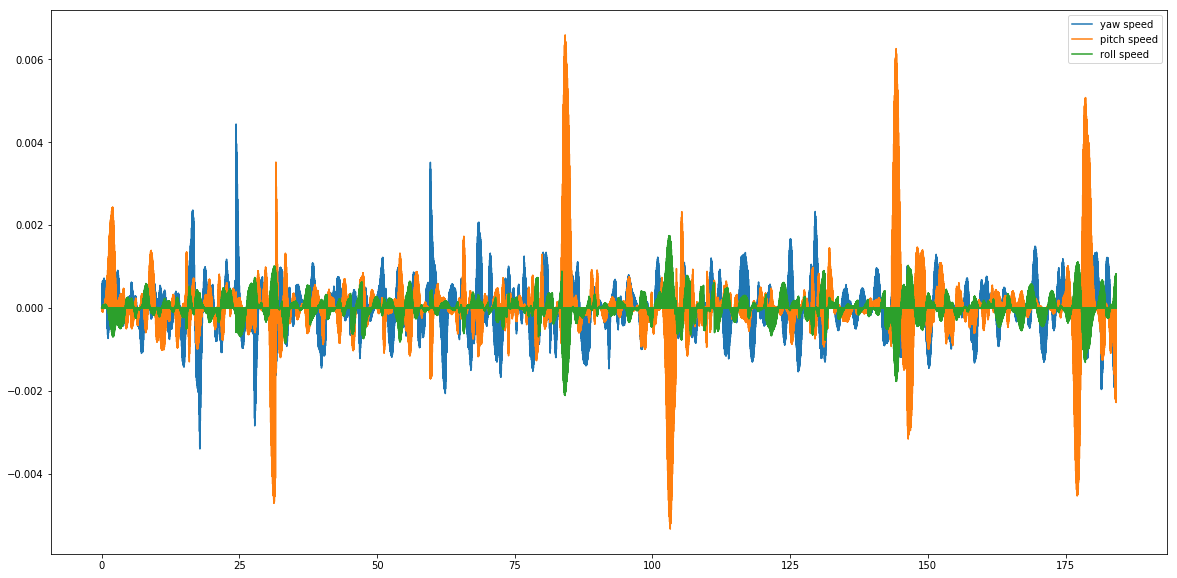

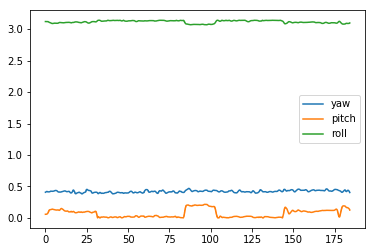

In [177]:
plt.figure(figsize=(20,10))
plt.plot(df['chrono'], accel[:, 0], label='yaw speed')
plt.plot(df['chrono'], accel[:, 1], label='pitch speed')
plt.plot(df['chrono'], accel[:, 2], label='roll speed')
plt.legend()
plt.show()

plt.plot(df['chrono'], angles[:, 0], label='yaw')
plt.plot(df['chrono'], angles[:, 1], label='pitch')
plt.plot(df['chrono'], angles[:, 2], label='roll')
plt.legend()
plt.show()

In [82]:
stds = df.var(axis=0)
match_cols = sorted(list(stds[stds > 10E-10].index))
print([col for col in match_cols if 'Subject' not in col and '_qua' in col])


['Head_quaw', 'Head_quax', 'Head_quay', 'Head_quaz', 'Jaw_quaw', 'Jaw_quay', 'LeftArmRoll_quaw', 'LeftArmRoll_quax', 'LeftArmRoll_quay', 'LeftArmRoll_quaz', 'LeftArm_quaw', 'LeftArm_quax', 'LeftArm_quay', 'LeftArm_quaz', 'LeftEye_quaw', 'LeftEye_quax', 'LeftEye_quay', 'LeftEye_quaz', 'LeftForeArmRoll_quaw', 'LeftForeArmRoll_quax', 'LeftForeArmRoll_quay', 'LeftForeArmRoll_quaz', 'LeftForeArm_quaw', 'LeftForeArm_quax', 'LeftForeArm_quay', 'LeftForeArm_quaz', 'LeftHandIndex1_quaw', 'LeftHandIndex1_quax', 'LeftHandIndex1_quay', 'LeftHandIndex1_quaz', 'LeftHandIndex2_quaw', 'LeftHandIndex2_quax', 'LeftHandIndex2_quay', 'LeftHandIndex2_quaz', 'LeftHandIndex3_quaw', 'LeftHandIndex3_quax', 'LeftHandIndex3_quay', 'LeftHandIndex3_quaz', 'LeftHandMiddle1_quaw', 'LeftHandMiddle1_quax', 'LeftHandMiddle1_quay', 'LeftHandMiddle1_quaz', 'LeftHandMiddle2_quaw', 'LeftHandMiddle2_quax', 'LeftHandMiddle2_quay', 'LeftHandMiddle2_quaz', 'LeftHandMiddle3_quaw', 'LeftHandMiddle3_quax', 'LeftHandMiddle3_quay',

In [ ]:
print(df.iloc[10]['chrono'])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd


a = np.random.rand(2000, 3)*10
t = np.array([np.ones(100)*i for i in range(20)]).flatten()
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})

def update_graph(num):
    data=df[df['time']==num]
    print(data.shape)
    print(data.x.shape)
    graph.set_data (data.x, data.y)
    graph.set_3d_properties(data.z)
    title.set_text('3D Test, time={}'.format(num))
    return title, graph, 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df[df['time']==0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 19, 
                               interval=40, blit=True)

plt.show()

In [ ]:
data=df[df['time']==0]
data.x

In [12]:
import numpy as np
from pyquaternion import Quaternion

np.set_printoptions(suppress=True) # Suppress insignificant values for clarity
v = np.array([0., 0., 1.]) # Unit vector in the +z direction
q0 = Quaternion(axis=[1, 1, 1], angle=0.0) # Rotate 0 about x=y=z
q1 = Quaternion(axis=[1, 1, 1], angle=2 * 3.14159265 / 3) # Rotate 120 about x=y=z
for q in Quaternion.intermediates(q0, q1, 8, include_endpoints=True):
    v_prime = q.rotate(v)
    print(v_prime)

[0. 0. 1.]
[ 0.14213118 -0.12416109  0.98202991]
[ 0.29457011 -0.22365854  0.92908843]
[ 0.44909878 -0.29312841  0.84402963]
[ 0.59738651 -0.32882557  0.73143906]
[ 0.73143906 -0.32882557  0.59738651]
[ 0.84402963 -0.29312841  0.44909879]
[ 0.92908843 -0.22365854  0.29457012]
[ 0.98202991 -0.12416109  0.14213118]
[ 1. -0.  0.]


In [17]:
q = Quaternion(x=0.1, y=0.2, z=0.3, w=0.1)
v = np.array([0., 0., 1.])
print(q)
for i in np.arange(10):
    v = q.rotate(v)
    print(v)

0.100 +0.100i +0.200j +0.300k
[0.66666667 0.66666667 0.33333333]
[-0.35555556  0.44444444  0.82222222]
[0.74962963 0.16296296 0.64148148]
[-0.14380247  0.87308642  0.46587654]
[ 0.29962798 -0.07631276  0.95099918]
[0.4244473  0.85918903 0.28572488]
[-0.23533663  0.18705178  0.95374436]
[0.78346953 0.41658789 0.46111823]
[-0.32267722  0.69086254  0.64698405]
[ 0.57583766 -0.01408297  0.81744276]


In [14]:
q

Quaternion(0.0, 0.0, 0.0, 0.0)